In [ ]:
!pip install youtube-transcript-api

In [1]:
import os
import json
import pandas as pd

userlog_path = "UserLog"
yt_urls = []
# list of micronotes ->[ [{'point': <string>, 'created_at': <number>}] ]
micro_notes = []
base_notes = []

for folder_number in range(1, 13):
    user_folder = f'P{folder_number}'
    print(f'Processing {user_folder}')
    user_folder_path = os.path.join(userlog_path, user_folder)
    if os.path.isdir(user_folder_path):
        folder_number = int(user_folder[1:])
        for subdir, _, files in os.walk(user_folder_path):
            for file in files:

                str_rep = ''
                
                file_path = os.path.join(subdir, file)
                if file == 'onboarding.json':
                    pass
                # if not file.lower().startswith('video1') and not file.lower().startswith('video2'): continue
                elif file.lower().startswith('video1') or file.lower().startswith('video2'):
                    video_data = {}
                    vd_data = {}
                    with open(file_path, 'r', encoding='utf-8') as f:
                        bullet_points_data = json.load(f)
                    np = [
                        {
                            'point': bpd['point'],
                            'time': bpd['note_taking_time']
                        }
                        for bpd in bullet_points_data['editHistory']
                    ]
                    init_created_at = np[0]['time']
                    np = np[1:-1] # discarding first and last noisy point
                    note_points = []
                    for i, n in enumerate(np):
                        time = init_created_at + n['time']
                        note_points.append({
                            'point': n['point'],
                            'created_at': time
                        })
                        init_created_at = time
                    yt_url = bullet_points_data['url']
                    
                    if folder_number % 2 == 0:
                        if file.lower().startswith('video1'):
                            base_notes.append(note_points)
                            yt_urls.append(yt_url)
                    else:
                        if file.lower().startswith('video2'):
                            base_notes.append(note_points)
                            yt_urls.append(yt_url)


Processing P1
Processing P2
Processing P3
Processing P4
Processing P5
Processing P6
Processing P7
Processing P8
Processing P9
Processing P10
Processing P11
Processing P12


In [2]:
yt_urls

['www.youtube.com/watch?v=',
 'www.youtube.com/watch?v=',
 'www.youtube.com/watch?v=',
 'www.youtube.com/watch?v=',
 'www.youtube.com/watch?v=',
 'www.youtube.com/watch?v=',
 'www.youtube.com/watch?v=yOgAbKJGrTA',
 'www.youtube.com/watch?v=P7yM0TKvUm4',
 'www.youtube.com/watch?v=P7yM0TKvUm4',
 'www.youtube.com/watch?v=yOgAbKJGrTA',
 'www.youtube.com/watch?v=yOgAbKJGrTA',
 'www.youtube.com/watch?v=P7yM0TKvUm4']

In [4]:
yt_urls[0] = 'www.youtube.com/watch?v=P7yM0TKvUm4'
yt_urls[1] = 'www.youtube.com/watch?v=yOgAbKJGrTA'
yt_urls[2] = 'www.youtube.com/watch?v=yOgAbKJGrTA'
yt_urls[3] = 'www.youtube.com/watch?v=P7yM0TKvUm4'
yt_urls[4] = 'www.youtube.com/watch?v=yOgAbKJGrTA'
yt_urls[5] = 'www.youtube.com/watch?v=yOgAbKJGrTA'

In [2]:
import pickle

with open('window.pkl', 'rb') as f:
    transcripts = pickle.load(f)

In [3]:
def change_attr(tr):
    return {
        'text': tr['text'],
        'offset': tr['start'], # changing attr name here
        'duration': tr['duration']
    }

updated_transcripts = []
for i, tr in enumerate(transcripts):
    if len(tr) != 0:
        updated_transcripts.append(list(map(change_attr, tr)))
    else:
        updated_transcripts.append([])

In [4]:
# point -> {'point':<string>, 'created_at':<number>}
def expand_point(point, transcript, WINDOW_SIZE=20000):
    expanded_point = {'point': point['point'], 'transcript': []}

    for line in transcript:
        tr_offset = line['offset'] * 1000.0 # converting to ms
        tr_end = (line['offset'] + line['duration']) * 1000.0 # converting to ms
        right = point['created_at']
        left = right - WINDOW_SIZE  # Assuming WINDOW_SIZE is defined elsewhere

        # there is partial or full overlapping between point and transcript
        if not (right < tr_offset) and not (left > tr_end):
            expanded_point['transcript'].append(line['text'])

    return expanded_point

In [5]:
def _size(base_note, updated_transcript, win):
    res = []
    for bn in base_note:
        r = expand_point(bn, updated_transcript, win)
        res.append(r)
    
    return res

In [6]:
from bert_score import score

def calculate_bert_score(resp):
    reference = [''.join(resp['transcript'])]
    candidate = [resp['point']]
    P, R, F1 = score(candidate, reference, lang='en', verbose=False)
    return {P, R, F1}

/home/codespace/.python/current/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
WINDOW = [5000, 10000, 20000, 30000, 40000, 50000]
scores = []

for k in range(len(WINDOW)):
    scores.append([])

for author in range(12):
    for i, win in enumerate(WINDOW):
        if len(transcripts[author]) != 0:
            res = _size(base_notes[author], updated_transcripts[author], win)
            for r in res:
                scores[i].append(calculate_bert_score(r))
        else:
            scores[i].append(0)
        print(f'Expansion for user P{author+1} with WINDOW size {win} done')

In [18]:
[sc.item() for sc in scores[0][0]]

[0.8059643507003784, 0.7981622219085693, 0.8020442724227905]

In [15]:
P = [0] * len(WINDOW)
R = [0] * len(WINDOW)
F_1 = [0] * len(WINDOW)

for i in range(len(WINDOW)):
    count = 0
    for score in scores[i]:
        s = [sc.item() for sc in score]
        P[i] += s[0]
        R[i] += s[1]
        F_1[i] += s[2]
        count += 1
    P[i] /= count
    R[i] /= count
    F_1[i] /= count

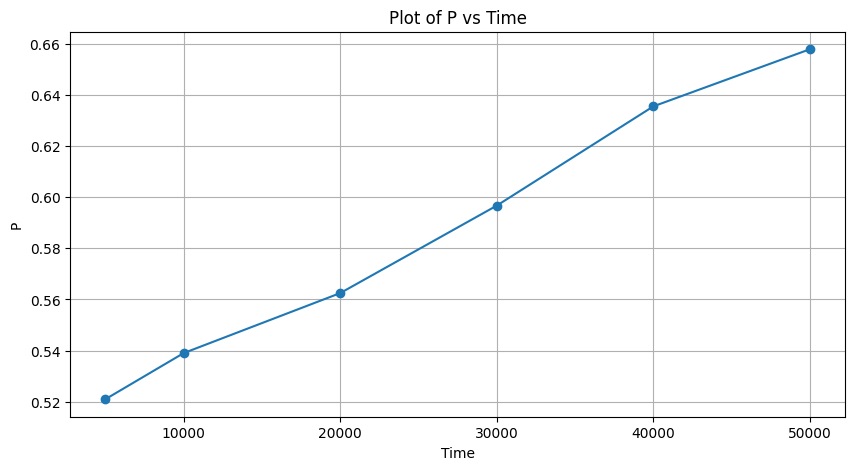

In [16]:
import matplotlib.pyplot as plt

# Create a plot
plt.figure(figsize=(10, 5))
plt.plot(WINDOW, P, marker='o', linestyle='-')

# Add labels and title
plt.xlabel('Time')
plt.ylabel('P')
plt.title('Plot of P vs Time')
plt.grid()

# Show the plot
plt.show()

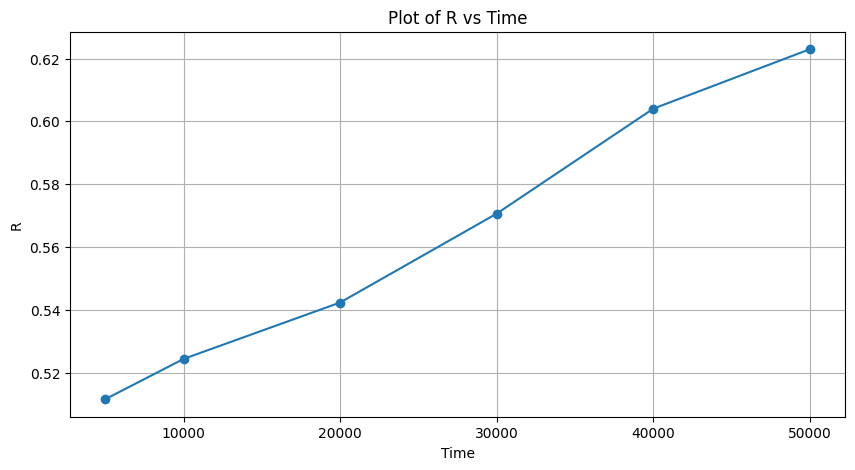

In [17]:
import matplotlib.pyplot as plt

# Create a plot
plt.figure(figsize=(10, 5))
plt.plot(WINDOW, R, marker='o', linestyle='-')

# Add labels and title
plt.xlabel('Time')
plt.ylabel('R')
plt.title('Plot of R vs Time')
plt.grid()

# Show the plot
plt.show()

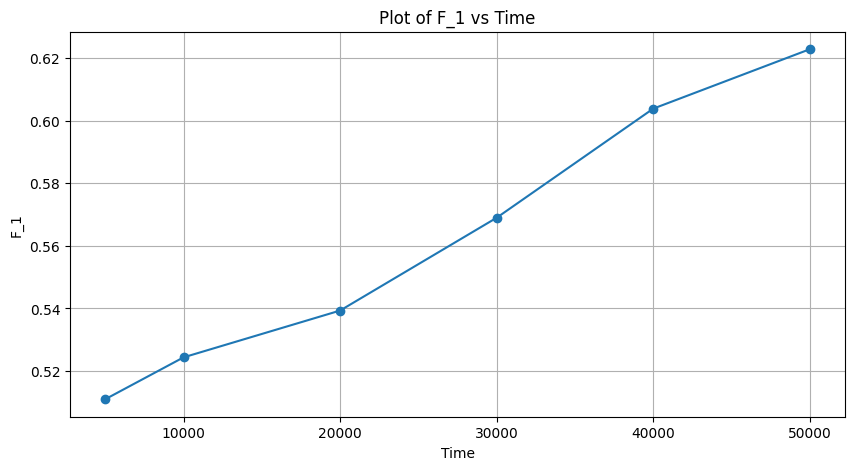

In [18]:
import matplotlib.pyplot as plt

# Create a plot
plt.figure(figsize=(10, 5))
plt.plot(WINDOW, F_1, marker='o', linestyle='-')

# Add labels and title
plt.xlabel('Time')
plt.ylabel('F_1')
plt.title('Plot of F_1 vs Time')
plt.grid()

# Show the plot
plt.show()

In [ ]:
updated_scores = []
for score in scores:
    updated_score = []
    for sc in score:
        updated_score.append([s.item() for s in sc])
    updated_scores.append(updated_score)

In [ ]:
P = []
R = []
F_1 = []

for updated_score in updated_scores:
    for usc in updated_score:
        P.append(usc[0])
        R.append(usc[1])
        F_1.append(usc[2])

In [ ]:
import matplotlib.pyplot as plt
author = 10 # for P11

time = []
for bn in base_notes[author]:
    time.append(bn['time'])

# Create a plot
plt.figure(figsize=(10, 5))
plt.plot(time, PRECISION[author], marker='o', linestyle='-')

# Add labels and title
plt.xlabel('Time')
plt.ylabel('P')
plt.title('Plot of P vs Time')
plt.grid()

# Show the plot
plt.show()